## Introduction to ML and OOD 

#### Resources:
   - [Scikit-learn documentation](https://scikit-learn.org/stable/modules/outlier_detection.html) 

#### For the next experiments our OOD class will be for samples with DF class and the rest will be considered In-distribution

In [2]:
import pandas as pd

groundtruth = pd.read_csv("../data/ISIC2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
oodist = list(groundtruth.index[groundtruth.DF == 1])
indist = list(groundtruth.index[groundtruth.NV == 1])

#### Let see our sample size for both groups in the csv file

In [3]:
len(indist), len(oodist)

(12875, 239)

#### Now we need to load the images associated to filtered ids
- Resize them to a common shape and return them as numpy arrays
- Associated to the ids for both In-distribution and Out-distribution

In [4]:
import os
from pathlib import Path
import numpy as np
from PIL import Image

X_data = []
ood_data = []
# get the path/directory
folder_dir = "../data/ISIC2019/ISIC_2019_Training_Input/"
images = Path(folder_dir).glob("*.jpg")

for i in images:
    # image = plt.imread(i)
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((224, 224), Image.Resampling.LANCZOS)).ravel()
    if i.stem in indist:
        X_data.append(img_resize)
    elif i.stem in oodist:
        ood_data.append(img_resize)
# images = list(images)
# X_array = np

#### Let see our sample size for both groups with loaded images

In [5]:
len(X_data), len(ood_data)

(12875, 239)

In [6]:
import numpy as np

X_array = np.array(X_data[:5000])
ood_array = np.array(ood_data)

In [7]:
y_ind = np.zeros(X_array.shape[0])  # not a OOD sample
y_ood = np.ones(ood_array.shape[0])  # an OOD sample
X = np.concatenate([X_array, ood_array])
y = np.concatenate([y_ind, y_ood])
print(X.shape, y.shape)

(5239, 150528) (5239,)


#### Let's visualize our data with a simple 2 component PCA
- Does this looks like an easy problem? Can you easily separate In-distribution from Out-distribution samples?

explained variance ratio (first two components): [0.45037332 0.16082151]


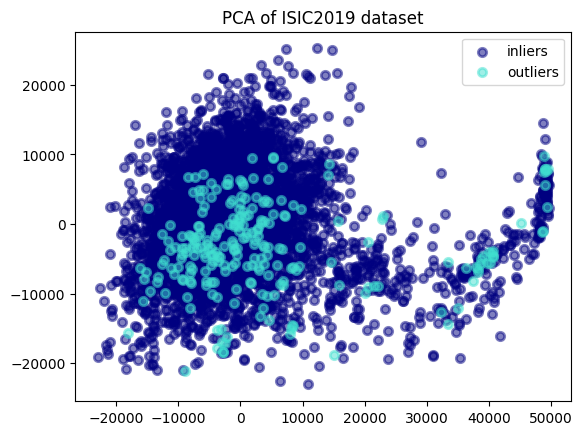

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import aux
import importlib

importlib.reload(aux)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

aux.plot_pca(X_pca, y)

plt.show()

## Isolation Forest

Resources:
- Liu, F.T., Ting, K.M. and Zhou, Z.H., 2012. [Isolation-based anomaly detection](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf). ACM Transactions on Knowledge Discovery from Data (TKDD), 6(1), pp.1-39. 

In [31]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, stratify=y, random_state=42
)

clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=200, random_state=0)

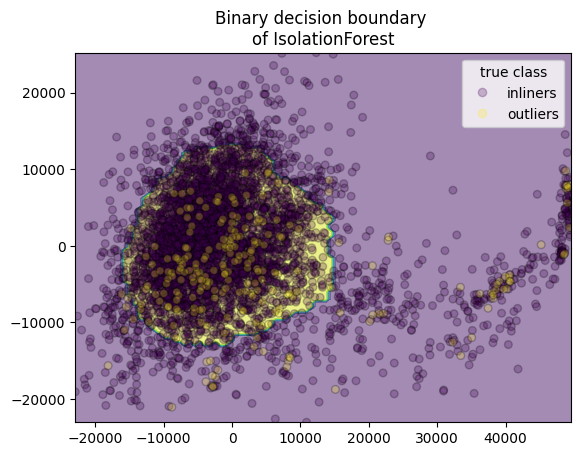

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_pca,
    response_method="predict",
    alpha=0.5,
)

sc = disp.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30, alpha=0.25, edgecolor="k")
handles, labels = sc.legend_elements()
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.legend(handles=handles, labels=["inliners", "outliers"], title="true class")
plt.show()

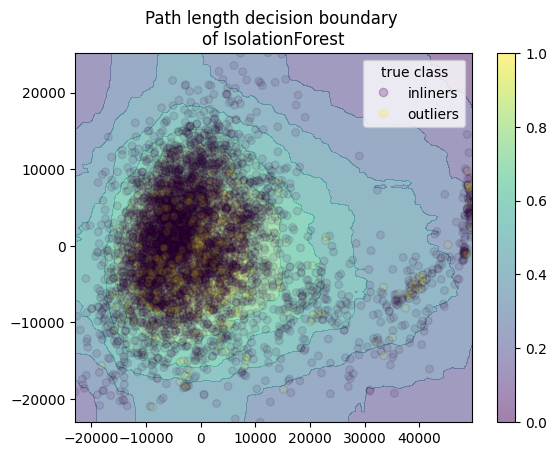

In [11]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_pca,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30, alpha=0.1, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.legend(handles=handles, labels=["inliners", "outliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

### Metrics to assess the outlier detection performance

In [33]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([1., 1., 1., ..., 1., 1., 1.])

In [41]:
from sklearn.metrics import classification_report, roc_curve, auc

fpr, tpr, thresholds_sorted = roc_curve(y_test, clf.predict(X_test))
aucuc = auc(fpr, tpr)
aucuc

0.542

#### How the raw scores from the Isolation forest look like?

(array([ 20.,  24.,  37.,  43.,  51.,  68.,  91., 145., 262., 569.]),
 array([-0.71156687, -0.6793815 , -0.64719614, -0.61501077, -0.5828254 ,
        -0.55064003, -0.51845467, -0.4862693 , -0.45408393, -0.42189857,
        -0.3897132 ]),
 <BarContainer object of 10 artists>)

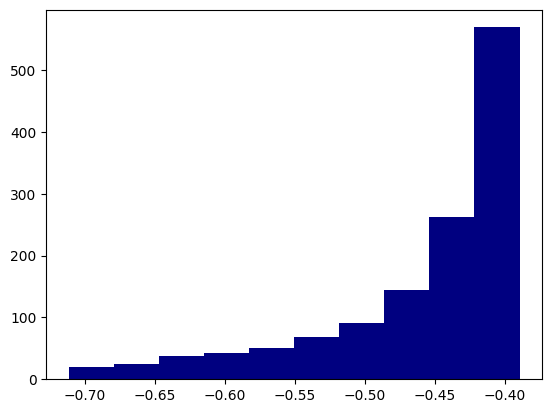

In [42]:
plt.hist(clf.score_samples(X_test), color="Navy")

In [35]:
print(
    classification_report(
        y_test,
        clf.predict(X_test),
        target_names=["Out-distribution", "In-distribution"],
    )
)

                  precision    recall  f1-score   support

Out-distribution       0.06      0.30      0.10        60
 In-distribution       0.96      0.78      0.86      1250

        accuracy                           0.76      1310
       macro avg       0.51      0.54      0.48      1310
    weighted avg       0.92      0.76      0.83      1310



### One Class SVM

In [36]:
from sklearn.svm import OneClassSVM

outliers_fraction = 0.15
onesvm = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
onesvm.fit(X_train)

OneClassSVM(gamma=0.1, nu=0.15)

(array([1.309e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.01503906, 0.03007813, 0.04511719, 0.06015625,
        0.07519531, 0.09023438, 0.10527344, 0.1203125 , 0.13535156,
        0.15039062]),
 <BarContainer object of 10 artists>)

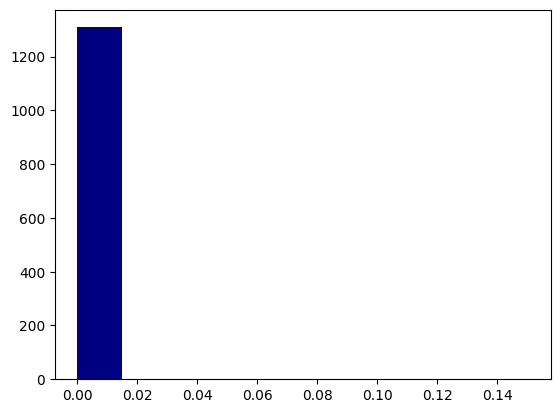

In [37]:
plt.hist(onesvm.score_samples(X_test), color="Navy")

In [43]:
from sklearn import metrics

fpr, tpr, thresholds_sorted = metrics.roc_curve(y_test, onesvm.predict(X_test))
aucuc = metrics.auc(fpr, tpr)
aucuc

0.5004

In [46]:
print(
    classification_report(
        y_test,
        clf.predict(X_test),
        target_names=["Out-distribution", "In-distribution"],
    )
)

                  precision    recall  f1-score   support

Out-distribution       0.06      0.30      0.10        60
 In-distribution       0.96      0.78      0.86      1250

        accuracy                           0.76      1310
       macro avg       0.51      0.54      0.48      1310
    weighted avg       0.92      0.76      0.83      1310



## Malaria study 

#### TODO by team

- Prepare numpy arrays with in-distribution and out-distribution labels
- Visualize PCA for all samples
- Run Isolation forest and One-SVM for malaria samples
- View raw anomalous scores for each method and run metrics